In [129]:
import matplotlib.pyplot as plt
import json
import polars as pl
import numpy as np
import sys
from PIL import Image
import os
import torch
import faiss
from src.pipeline.feature_extractor import FeatureExtractor
from src.geoclip import GeoCLIP
from transformers import AutoModel, AutoProcessor, AutoImageProcessor

sys.path.append("..")
from src.utils import haversine, read_index
import pandas as pd

In [92]:
labels2id = {
    "religious_site": 0,
    "historic_civic": 1,
    "monument_memorial": 2,
    "tower": 3,
    "bridge": 4,
    "gate": 5,
    "museum_culture": 6,
    "leisure_park": 7,
    "urban_scene": 8,
    "natural": 9,
    "unknown": -1,
}

base_img_path = "../datasets/mp16-reason"

In [169]:
s4_index, s4_ref_meta = read_index("../index/s4_filtered")
s4_index.hnsw.efSearch = 128
s4_ref_meta = s4_ref_meta["metadata"]

clip_index, clip_ref_meta = read_index("../index/clip_filtered")
clip_index.hnsw.efSearch = 128
clip_ref_meta = clip_ref_meta["metadata"]

In [132]:
query_img = Image.open("Tokyo_Skytree_2014.jpg")
query_img_size = query_img.size[::-1]
topk = 100

In [ ]:
clip_processor = AutoProcessor.from_pretrained("openai/clip-vit-large-patch14")
clip_model = (
    AutoModel.from_pretrained("openai/clip-vit-large-patch14").to("cuda").eval()
)

Loading weights:   0%|          | 0/590 [00:00<?, ?it/s]

CLIPModel LOAD REPORT from: openai/clip-vit-large-patch14
Key                                  | Status     |  | 
-------------------------------------+------------+--+-
text_model.embeddings.position_ids   | UNEXPECTED |  | 
vision_model.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [109]:
query_clip = clip_processor(query_img, return_tensors="pt")
with torch.no_grad():
    query_emb = (
        clip_model.get_image_features(
            **{k: v.to("cuda") for k, v in query_clip.items()}
        )
        .pooler_output.cpu()
        .numpy()
    )
    faiss.normalize_L2(query_emb)
    sim, ind = clip_index.search(query_emb, topk)
    flat_D, flat_I = sim.reshape(-1), ind.reshape(-1)
    sorted_sim_ids = (
        pd.DataFrame({"idx": flat_I, "score": flat_D})
        .sort_values(by="score", ascending=False)
        .drop_duplicates(subset="idx")
        .idx.tolist()
    )
    sim_meta = [clip_ref_meta[ii] for ii in sorted_sim_ids][:topk]

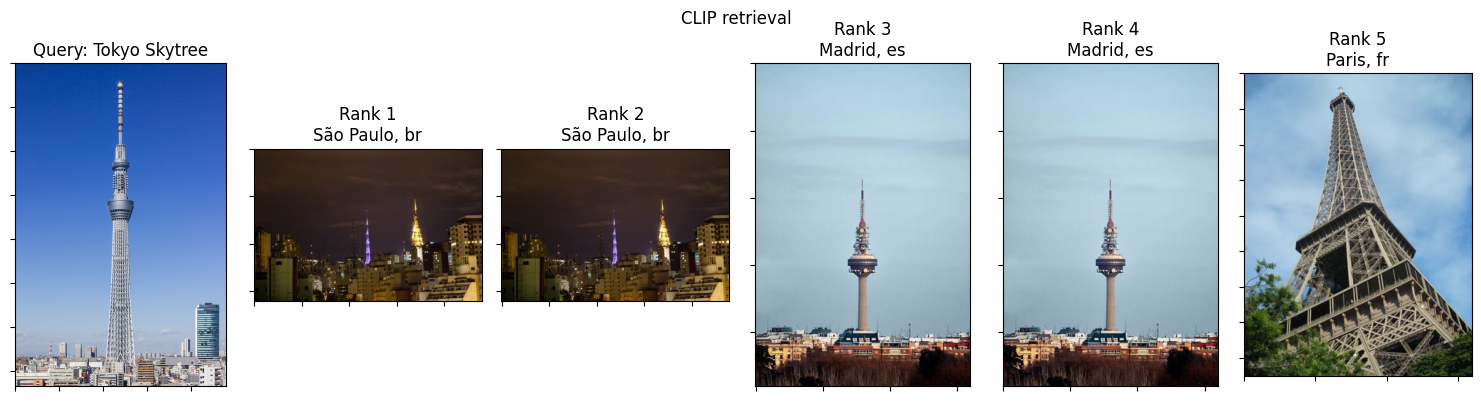

In [187]:
fig, ax = plt.subplots(1, 6, figsize=(15, 4))
for i in range(6):
    if i == 0:
        ax[i].imshow(Image.open("Tokyo_Skytree_2014.jpg"))
        ax[i].set_title("Query: Tokyo Skytree")
    else:
        meta = sim_meta[i - 1]
        ax[i].imshow(Image.open(os.path.join(base_img_path, meta["IMG_ID"])))
        ax[i].set_title(f"Rank {i}\n{meta['city']}, {meta['country_code']}")

    ax[i].set_xticklabels([])
    ax[i].set_yticklabels([])

plt.suptitle("CLIP retrieval")
plt.tight_layout()
plt.savefig("clip_result.png")
plt.show()

In [ ]:
mask_processor = AutoImageProcessor.from_pretrained(
    "facebook/mask2former-swin-large-ade-semantic"
)
extractor = FeatureExtractor(device="cuda")
geo = GeoCLIP().to("cuda")

Loading weights:   0%|          | 0/782 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/590 [00:00<?, ?it/s]

CLIPModel LOAD REPORT from: openai/clip-vit-large-patch14
Key                                  | Status     |  | 
-------------------------------------+------------+--+-
text_model.embeddings.position_ids   | UNEXPECTED |  | 
vision_model.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [185]:
# segment
query_s4 = mask_processor(query_img, return_tensors="pt")
s4_out = extractor(query_s4, [query_img], [query_img_size])
# predict gps
gps, _ = geo.predict("Tokyo_Skytree_2014.jpg", top_k=1)
gps = gps.view(-1).numpy()
# query
query_emb = s4_out["alpha_embeddings"][0].astype("float32")
faiss.normalize_L2(query_emb)
sim, ind = s4_index.search(query_emb, topk)
flat_D, flat_I = sim.reshape(-1), ind.reshape(-1)
s4_sim_meta = [s4_ref_meta[ii] for ii in flat_I]

# remove duplicate
s4_sim_meta = (
    pl.DataFrame([s4_ref_meta[ii] for ii in flat_I]).unique(subset=["idx"]).to_dicts()
)
ref_gps = [[item["LAT"], item["LON"]] for item in s4_sim_meta]
# rerank
ranks = np.argsort(haversine(gps, ref_gps))[::-1]
s4_sim_meta = [s4_sim_meta[i] for i in ranks]

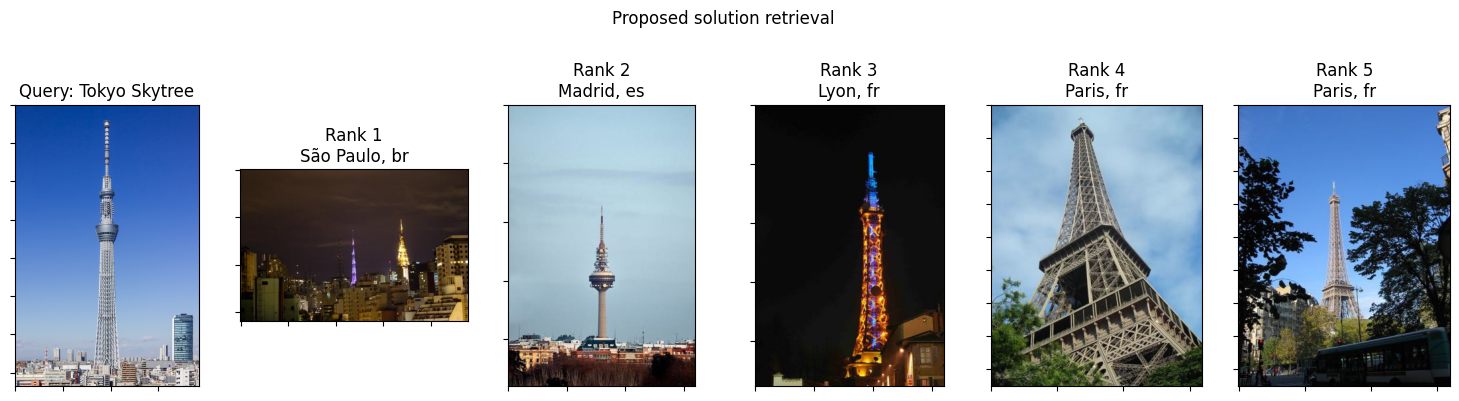

In [189]:
fig, ax = plt.subplots(1, 6, figsize=(15, 4))
for i in range(6):
    if i == 0:
        ax[i].imshow(Image.open("Tokyo_Skytree_2014.jpg"))
        ax[i].set_title("Query: Tokyo Skytree")
    else:
        meta = s4_sim_meta[i - 1]
        ax[i].imshow(Image.open(os.path.join(base_img_path, meta["IMG_ID"])))
        ax[i].set_title(f"Rank {i}\n{meta['city']}, {meta['country_code']}")

    ax[i].set_xticklabels([])
    ax[i].set_yticklabels([])

plt.suptitle("Proposed solution retrieval\n\n")
plt.tight_layout()
plt.savefig("s4_result.png")
plt.show()

(3, 100)